Из открытых библиотек рассматривал Tesseract и EasyOCR. Для русского языка у меня easyocr показывал лучшие результаты (хотя возможно использовал не оптимальные настройки tesseract), поэтому решил использовать его.

In [ ]:
!pip install easyocr >> None
!pip install editdistance >> None

In [ ]:
import easyocr
import torch
import imutils
import numpy as np
from copy import deepcopy
import editdistance
from skimage import exposure, filters
import cv2

from google.colab.patches import cv2_imshow

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
reader = easyocr.Reader(['ru'], gpu=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

In [ ]:
!tar -xvf "/content/dataforocr.tar" -C "/content/dataforocr/"  >> None

tar: A lone zero block at 5944


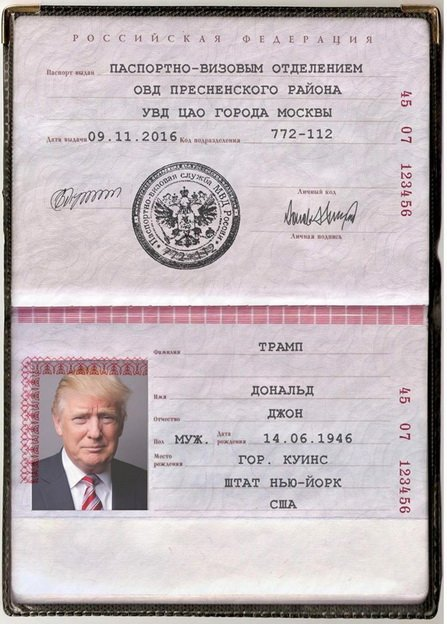

In [ ]:
path = "/content/dataforocr/0.jpeg"

img = cv2.imread(path)
cv2_imshow(img)

идея в том, чтобы определить рамку для лица на изображении и, используя ее координаты, находить рамки для фио. рассматривал только варианты правильного расположения изображения, но, при необходимости, можно дополнительно определять ориентацию.

In [ ]:
def face_coords(img):
    """
    функция для нахождения координат рамки лица на изображении
    """
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    face = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
    )[-1]
    return face

упростим немноого задачу ридеру, чтоб искал только нужные символы

In [ ]:
# blocklist = '0123456789()[]@{}$<>/""+_₽;=|\~^.\\?%!€* :І'
allowlist = 'уБмШэ-ЙхйПЪлЧшАнГЁЮЬгётЭвЖХяУьдДЕВКРъЦЫжЛпрфНФщеч`ыСЩи3ИбМсОокЯаТзюц'

идея в том, что easyocr может возвращать не только текст, но и числовую меру уверенности, которую можно использовать прогоняя изображение через разные фильтры и отбирая результат с максимальным скором.

In [ ]:
def PreprocessingVar0(img, show=False):
    """
    только ресайзинг в качестве предобработки
    (для лучшего чтения ридером)
    """
    img_resized = imutils.resize(img, 400)

    if show:
        cv2_imshow(img_resized)

    return img_resized


def PreprocessingVar1(img, show=False):
    """
    первый фильтр с блюрингом
    """
    img_resized = imutils.resize(img, 400)
    # gray_cut = cv2.fastNlMeansDenoising(gray_cut, None, 15, 3, 45) 
    
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))
    blurred = cv2.medianBlur(img_resized, 3)
    preprocessed = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, rectKernel)

    if show:
        cv2_imshow(preprocessed)

    return preprocessed


def PreprocessingVar2(img, show=False):
    """
    второй фильтр с деноизингом
    """
    img_resized = imutils.resize(img, 400)
    denoised = cv2.fastNlMeansDenoising(img_resized, None, 15, 3, 45) 
    
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
    preprocessed = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, rectKernel)

    if show:
        cv2_imshow(preprocessed)
    
    return preprocessed
    

def easyocr_read_image(image):
    """
    функция для чтения обрезанных изображений, возвращает текст и скор, полученный
    ридером easyocr
    """
    reader_res = reader.readtext(image, detail=1, paragraph=False, allowlist=allowlist)
    if reader_res:
        text = deepcopy(sorted(reader_res, key=lambda x: x[-1]))[-1][1].upper()
        score = deepcopy(sorted(reader_res, key=lambda x: x[-1]))[-1][2]
    else:
        text = ''
        score = 0

    return text, score

находим прямоугольники с фамилией, именем и отчеством для каждого изображения, обрабатываем методом preproc, сохраняем в папке save_dir. результат ридера записываем в 3 списка с распознанными фамилиями, именами и отчествами

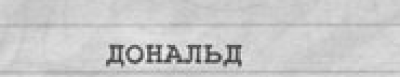

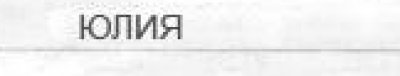

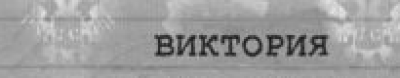

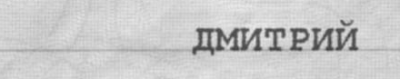

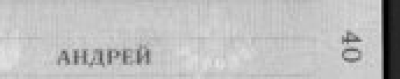

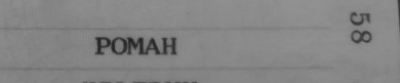

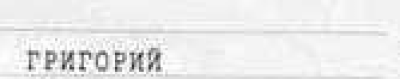

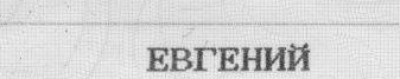

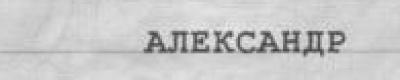

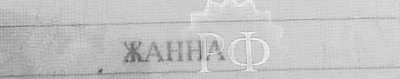

In [645]:
preproc=PreprocessingVar0
save_dir='/content/dataforocr/snp'
surnames, names, patronymics = [], [], [] 
for i in range(0, 10):
    if i != 4:
        img = cv2.imread(f'/content/dataforocr/{i}.jpeg')
    else:
        img = cv2.imread(f'/content/dataforocr/{i}.png')

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    (x, y, w, h) = face_coords(img)

    # surname = PreprocessingVar1(gray[y-3*h//2:y-h//3, x+2*w:x+9*w//2])
    img = gray[y-11*h//10:y-4*h//10, x+2*w:x+9*w//2]
    surname = preproc(img)
    # cv2_imshow(surname)
    cv2.imwrite(f'{save_dir}/surname{i}.png', surname)
    name = preproc(gray[y-h//3:y+h//6, x+2*w:x+9*w//2])  
    cv2_imshow(name)
    cv2.imwrite(f'{save_dir}/name{i}.png', name)
    patronymic = preproc(gray[y+h//9:y+h//2, x+2*w:x+9*w//2]) 
    # cv2_imshow(patronymic)
    cv2.imwrite(f'{save_dir}/patronymic{i}.png', patronymic)
    
    # surname1, score1 = PreprocessingVar1(surname)
    # surname2, score2 = PreprocessingVar2(surname)
    # if score1 > score2:
    #     surnames.append([surname1, score1])
    # else:
    #     surnames.append([surname2, score2])
    surnames.append(list(easyocr_read_image(surname)))
    names.append(list(easyocr_read_image(name)))
    patronymics.append(list(easyocr_read_image(patronymic)))

In [649]:
easyocr_pred = [text for i in range(10) for text in (surnames[i][0], names[i][0], patronymics[i][0])]
easyocr_pred

['ТРАНП',
 'ДОНАЛЬД',
 'ДОН',
 'ХАЛАБУДИНА',
 'ЮЛИЯ',
 'АЛЕКСЕЕВНА',
 'ШАПОШНИКОВА',
 'ВИКТОРИЯ',
 'НИКОЛАЕВНА',
 'ДАЙМОНД',
 'ДМИТРИЙ',
 'АЛЕКСЕЕВИЧ',
 'КШКШАН',
 'АНДРЕН',
 'ИНДРЕЕНИЧ',
 'МАКАРОВ',
 'РОМАН',
 'ЮРЬЕВИЧ',
 'НАСЛЕВСНТЯ',
 'ГЕШТАЕ-Т',
 'ПЕТЕОЕНЧ',
 'ИМЯРЕК',
 'ЕВГЕНИЙ',
 'АЛЕКСАНДРОВИЧ',
 'КУЛЕВАНОВ',
 'АЛЕКСАНДР',
 'ИГОРЕВИЧ',
 'КАКАЕВА',
 'ЖАННРФ',
 'АНАТОЛЬЕВНА']

In [611]:
# файл с метками для тестовых изображений

with open('/content/real_names.txt') as f:
    real_names = f.read()

real_names = [text for name in real_names.split(',') for text in name.split()]

попробуем обучить собственную базовую модель. для этого построил датасет на 30к записей с помощью библиотеки https://github.com/Belval/TextRecognitionDataGenerator. в ней добавил русский язык со шрифтом courier_new, который показался похожим на тот, что используется в паспортах, также добавил варианты фона из паспортов. использованные параметры для генерации: 
generator = GeneratorFromRandom(
    count=30000,
    size=64,
    blur=2,
    random_blur=True,
    background_type=3,
    use_numbers=False,
    use_symbols=False,
    language='ru',
    skewing_angle=2,
    random_skew=True,
    image_mode='L',
    margins=(20, 50, 15, 100),
    distorsion_type=3
)
в качестве базового алгоритма использовал https://github.com/wlinna/russian-ocr

In [629]:
import os
import os.path
import time

import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torch.nn.utils.rnn import pack_padded_sequence

import IPython

In [ ]:
!tar -xvf "/content/gen_data3.tar" -C "/content/generated3"  >> None

tar: A lone zero block at 450222


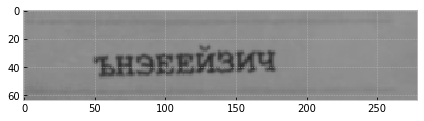

In [628]:
path = "/content/generated3/12000.png"
img = io.imread(path)
io.imshow(img)
# img = resize(img, (32, 340))
# io.imshow(img)

In [ ]:
# A special whitespace symbol. NOTE: this is a special kind of whitespace. It
# represents the whitespace between two consecutive letters, while normal
# space character represent a space of width 1.
# 'в^о' => 'во', but 'в о' => 'в о' 
WS_SYMBOL = '^'
SYMBOL_SET = WS_SYMBOL + ' -АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
WIDTH = 10
WS_CODE = SYMBOL_SET.index(WS_SYMBOL)

def text_to_numbers(text: str) -> np.array:
    return np.array([SYMBOL_SET.index(c) for c in text], dtype=np.int64)

def numbers_to_text(arr) -> str:
    return ''.join([SYMBOL_SET[code].upper() for code in arr])

def decode_sequence(seq):
    out = []
            
    current_code = None
    for i, v in enumerate(seq):
        if v == current_code:            
            continue

        current_code = v
        if v == WS_CODE:
            current_code = None
            continue
                    
        out.append(v)
                    
    return ''.join(numbers_to_text(out))

def test_decode_sequence(input, expected):
    numbers = text_to_numbers(input)
    result = decode_sequence(numbers)
    assert result == expected, "%s == %s" % (result, expected)

test_decode_sequence('АА^АА', 'АА')
test_decode_sequence('Я^В^Е^Р^Т^У^^', 'ЯВЕРТУ')

def decode_batch(input):
    """
    input in shape: [B, seq, feature]
    """

    # From the last dimension, choose the indices with highest
    # probabilities. These indices point to SYMBOL_SET
    maxed = torch.argmax(input.cpu(), -1).numpy()
    # [B, seq] : each value is an index to SYMBOL_SET
    return [decode_sequence(seq) for seq in maxed]

def load_image(path: str):
    img = io.imread(path)
    img = resize(img, (32, 340))
    img = torch.from_numpy(img).view(1, 32, 340).float()
    return img
    
class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        # Yes, all samples must be PNG files
        self.sample_ids = [f[:(f.rindex('.'))] for f in os.listdir(data_path) if f.endswith('.png')]
        print(self.sample_ids[0])
    
    def __len__(self):
        return len(self.sample_ids)
    
    def __getitem__(self, i):

        sample_path = self.data_path + '/' + self.sample_ids[i] 
        # print("sample_path", sample_path)
        img = load_image(sample_path + '.png')
        with open(sample_path + '.gt.txt') as f:
            label = f.read().strip('\n')
            missing_chars = WIDTH - len(label)
            if missing_chars > 0:
                label += ' ' * missing_chars
        
        return (img, text_to_numbers(label), len(label))
        

In [ ]:
# добавим несколько слоев и дропауты

CNN_OUT_CHANS = 160
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 40, 3, padding=1),
            nn.Dropout(0.5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(40, 80, 3, padding=1),
            nn.Dropout(0.5),
            nn.MaxPool2d(2),
            nn.ReLU(),   
            nn.Conv2d(80, 120, 3, padding=1),
            nn.Dropout(0.5),
            nn.ReLU(),  
            nn.Conv2d(120, CNN_OUT_CHANS, 3, padding=1),
            nn.ReLU()           
        ) 

        self.avgpool = nn.AdaptiveAvgPool2d((1, None))

        self.classifier = nn.Linear(CNN_OUT_CHANS, len(SYMBOL_SET))
        self.log_softmax = nn.LogSoftmax(dim=2)

        
    def forward(self, x):
        # Image size: 340 x 32
        # [B, Cin, Hin, Win]:     [B, 1, 32, 340]
        x = self.conv(x)    #     [B, 160, 8, 85]
        x = self.avgpool(x) #     [B, 160, 1, 85]

        # Reshape to the format expected by a Linear layer : [B, *, features]
        x = x.permute(0, 3, 1, 2).view(x.size(0), x.size(3), -1)
        
        x = self.classifier(x) #  [B, seq_len (85), features = |symbol_set|]
        # log_softmax expects inputs in the following shape
        x = x.permute(1, 0, 2) #  [seq_len (85), B, features = |symbol_set|]
        x = self.log_softmax(x)
        return x
        

In [ ]:
def compute_accuracy(net, valid_loader):
    def simplify(str_in):
        return str_in.strip().replace('  ', ' ')

    net.eval()
    
    with torch.no_grad():
        total_inaccuracy = 0
        num_comparisons = 0
        for i, (images, targets, lengths) in enumerate(valid_loader):
            if i > 1000: break

            images = images.to(device)
            targets = targets.to(device)
            outputs = net(images)
            
            outputs = outputs.permute(1, 0, 2)
            outs_decoded = decode_batch(outputs)
            targets_decoded = [numbers_to_text(t) for t in targets]

            for j in range(len(outs_decoded)):
                decoded_out, target_out = simplify(outs_decoded[j]), simplify(targets_decoded[j])

                normalizer = max(len(decoded_out), len(target_out))
                if normalizer != 0: # both strings are non-empty
                    inaccuracy = editdistance.eval(decoded_out, target_out) / normalizer
                    total_inaccuracy += inaccuracy

            num_comparisons += len(outs_decoded)
            
        average_inaccuracy = total_inaccuracy / num_comparisons

        return 1 - average_inaccuracy

In [ ]:
dataset = MyDataset('/content/generated3')
training_ratio = 0.9
indices = list(range(len(dataset)))
np.random.shuffle(indices)
split = int(training_ratio * len(dataset))
train_indices, valid_indices = indices[:split], indices[split:]
print("Total samples in the dataset:", len(indices))
print("Split:", split)
print("Train samples:", len(train_indices), ", validation samples:", len(valid_indices))
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(dataset, batch_size=32, num_workers=2, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=5, num_workers=2, sampler=valid_sampler)

744
Total samples in the dataset: 30000
Split: 27000
Train samples: 27000 , validation samples: 3000


In [ ]:
net = MyNet().to(device)

In [ ]:
# net.load_state_dict(torch.load('/content/best_model.pth'))

<All keys matched successfully>

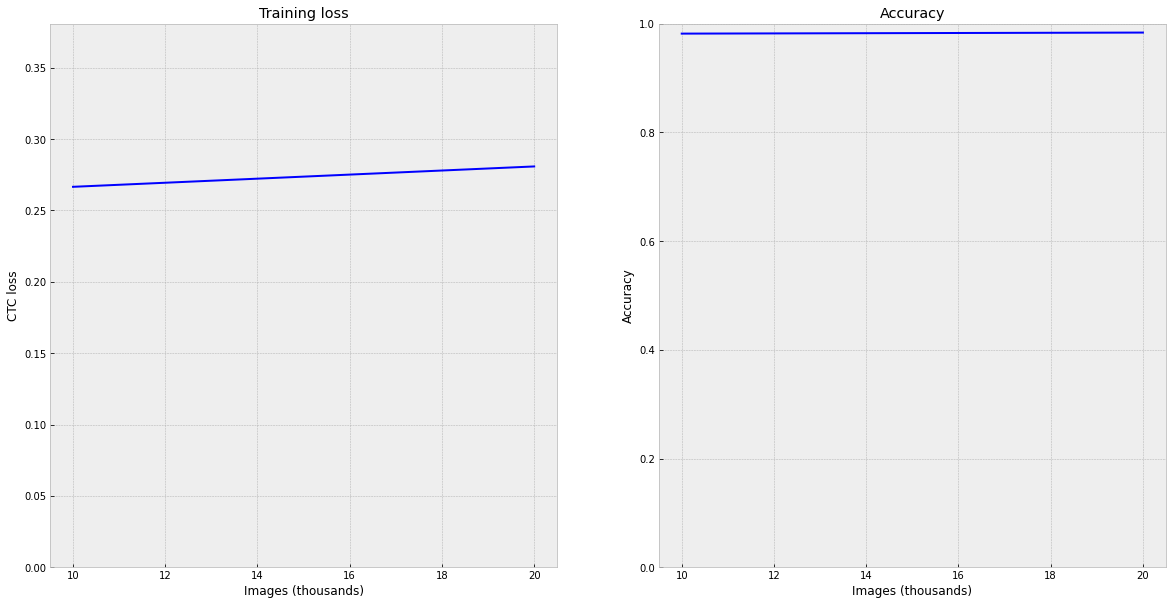

Loss: 0.28081297874450684
Accuracy: 0.9836867456617456
Epoch: 0
Time it took to train the model: 123.56997290199797


In [631]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

CHECKPOINT_INTERVAL = 10000
EPOCHS = 1   # дообучал модель, основной график в изображен в конце ноутбука

images_since_save = 0

start_epoch = 0


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].clear()
axes[1].clear()
IPython.display.clear_output(wait=True)
IPython.display.display(fig)

it = 0
iterations = []
accuracy_axis = []
losses_axis = []

criterion = nn.CTCLoss()

start_time = time.perf_counter()

for epoch in range(start_epoch, EPOCHS):
    for i, (images, labels, lengths) in enumerate(train_loader):
        net.train()
        images = images.to(device)
        targets = labels.to(device)

        outputs = net(images)
        
        net.zero_grad()
        
        input_lengths = torch.zeros(len(lengths)).type(torch.IntTensor).to(device)
        input_lengths.fill_(85)


        loss = criterion(outputs, targets, input_lengths, lengths)

        loss.backward()
        optimizer.step()

        
        images_since_save += len(images)
        
        if images_since_save > CHECKPOINT_INTERVAL:
            it += images_since_save
            iterations.append(it)
            losses_axis.append(loss.item())

            images_since_save = 0

            print("Computing accuracy...")
            accuracy = compute_accuracy(net, valid_loader)
            if accuracy_axis and accuracy > max(accuracy_axis):
                print("Saving the new best result")
                torch.save(net.state_dict(), '/content/best_model.pth')

            accuracy_axis.append(accuracy)
            
            iter_axis = np.array(iterations) // 1000
            
            axes[0].clear()
            axes[0].set(title='Training loss',
                        xlabel='Images (thousands)',ylabel='CTC loss')
            axes[0].set_ylim(ymin=0, ymax=max(losses_axis) + 0.1)
            axes[0].plot(iter_axis, losses_axis, 'b-')
            
            
            axes[1].clear()
            axes[1].set(title='Accuracy',
                        xlabel='Images (thousands)', ylabel='Accuracy')
            axes[1].set_ylim(ymin=0, ymax=1)
            axes[1].plot(iter_axis, accuracy_axis, 'b-')
            
            IPython.display.clear_output(wait=True)
            IPython.display.display(fig)
            # print("Saved state to checkpoint", fname)
            print("Loss:", loss.item())
            print("Accuracy:", accuracy)
            print("Epoch:", epoch)
            plt.pause(0.005)
            
    
print("Time it took to train the model:", time.perf_counter() - start_time)

In [642]:
net.load_state_dict(torch.load('/content/best_model.pth'))

<All keys matched successfully>

In [ ]:
def simplify(str_in):
    return str_in.strip().replace('  ', ' ')

def text_accuracy(preds, real=real_names):
    """
    считаем точность списка предсказаний относительно списка правильных значений
    """
    total_inaccuracy = 0
    for i, target in enumerate(real):
        pred, target = simplify(preds[i]), simplify(target)
        normalizer = max(len(pred), len(target))
        if normalizer != 0:
            inaccuracy = editdistance.eval(pred, target)
            total_inaccuracy += inaccuracy / normalizer
        
    average_inaccuracy = total_inaccuracy / len(real)
    return 1 - average_inaccuracy

In [632]:
total_inaccuracy = 0

for i in valid_indices:
    path = f"/content/generated3/{i}."
    img = io.imread(path+'png')
    pred = easyocr_read_image(img)[0]

    with open(path+'gt.txt') as f:
        target = f.read()

    pred_s, target_s = simplify(pred), simplify(target)
    normalizer = max(len(pred_s), len(target_s))
    if normalizer != 0:
        inaccuracy = editdistance.eval(pred_s, target_s)
        total_inaccuracy += inaccuracy / normalizer


average_inaccuracy = total_inaccuracy / len(valid_indices)
print('easyocr accuracy on val dataset:', 1 - average_inaccuracy)

easyocr accuracy on val dataset: 0.8038363275613277


как видим easyocr спавился хуже (0.8 точность против 0.98), что можно объяснить специфичным датасетом или переобученностью кастомной модели

['ЫКАБНА  ']

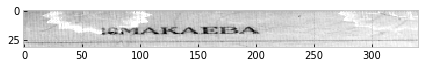

In [673]:
def one_image_ocr(path, net=net, device=device, show=True):
    """
    функция для распознования текста на одном изображении 
    """

    net.eval()

    with torch.no_grad():

        img = io.imread(path)

        img = resize(img, (32, 340))
        v_min, v_max = np.percentile(img, (0.02, 97.8))
        img = exposure.rescale_intensity(img, in_range=(v_min, v_max))

        if show:
            io.imshow(img, cmap=plt.cm.gray)

        img = torch.from_numpy(img).view(1, 1, 32, 340).float()
        img = img.to(device)
        outputs = net(img)
        
        outputs = outputs.permute(1, 0, 2)
        outs_decoded = decode_batch(outputs)

        return outs_decoded

one_image_ocr('/content/dataforocr/snp/surname9.png')

In [674]:
model_predicts = []

for i in range(10):
    for part in ('surname', 'name', 'patronymic'):
        model_predicts.extend(one_image_ocr(f'/content/dataforocr/snp/{part}{i}.png', show=False))

model_predicts, text_accuracy(model_predicts)

(['ТЕАМ',
  'ДОНАЛЬД',
  'ДЩЖОН',
  'ХБУДЙР ',
  'НОПИ',
  'АПСКОССПГА',
  'ШАПЭШНИКОВА  ',
  'ВИКТОРИЯ',
  'ПИКОЛАЕБПА  ',
  'ДАЙМОНД  ',
  'ДМИТРИЙ ',
  'АЛЕКСЕЕИЧ',
  'Й',
  'НС',
  'НННЧС',
  'Х ',
  'РМАНЭ  ',
  'РНЧВВЗЕС  ',
  'ЫАДРЬКЗ',
  'ГРХГОРЙЙ',
  'ПЕТРОЗЙЧ',
  'НИМЯРКК ',
  'ЕНГЕННН',
  'АЕКСАНЦЛРХПНЦ ',
  'КУЗЕВАНОВ ',
  'АЛЕХКСАНДР ',
  'ИГОРЕВИЧ ',
  'ЫКАБНА  ',
  'ЖННЗ',
  'ПГЛП'],
 0.5675010175010176)

In [675]:
print('easyocr accuracy passport:', text_accuracy(easyocr_pred))
print('easyocr accuracy passport:', text_accuracy(model_predicts))

easyocr accuracy passport: 0.8653174603174603
easyocr accuracy passport: 0.5675010175010176


на реальным данных easyocr справился значительно лушче, наша модель переобучилась под датасет. попробуем провести предобработку изображений

In [692]:
preproc=PreprocessingVar1
save_dir='/content/dataforocr/snp'
surnames, names, patronymics = [], [], [] 
for i in range(0, 10):
    if i != 4:
        img = cv2.imread(f'/content/dataforocr/{i}.jpeg')
    else:
        img = cv2.imread(f'/content/dataforocr/{i}.png')

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    (x, y, w, h) = face_coords(img)

    surname = preproc(gray[y-11*h//10:y-4*h//10, x+2*w:x+9*w//2])
    cv2.imwrite(f'{save_dir}/surname{i}.png', surname)
    name = preproc(gray[y-h//3:y+h//6, x+2*w:x+9*w//2])  
    cv2.imwrite(f'{save_dir}/name{i}.png', name)
    patronymic = preproc(gray[y+h//9:y+h//2, x+2*w:x+9*w//2]) 
    cv2.imwrite(f'{save_dir}/patronymic{i}.png', patronymic)
    
    surnames.append(list(easyocr_read_image(surname)))
    names.append(list(easyocr_read_image(name)))
    patronymics.append(list(easyocr_read_image(patronymic)))

In [693]:
easyocr_pred = [text for i in range(10) for text in (surnames[i][0], names[i][0], patronymics[i][0])]
easyocr_pred

['ТРАМП',
 'ДОНАЛЬД',
 'ДЖОН',
 'ХАЛАБУДИНА',
 'ЮЛИЯ',
 'АЛЕКСЕЕВНА',
 'ШАПОШНИКОВА',
 'ВИКТОРИЯ',
 'НИКОЛАЕВНА',
 'ДАЙМОНД',
 'ДМИТРИЙ',
 'АЛЕКСЕЕВИЧ',
 'СОКОЛОВ',
 'АНДРЕИ',
 'АНДТТТИИЧ',
 'МАКАРОВ',
 'РОМАН',
 'ЮРЬЕВИЧ',
 'ВАСЛЕРСКИЙ',
 'ГРИГОРИЯ',
 'ПЕТРОВИЧ',
 'ИМЯРЕК',
 'ЕВГЕНИЙ',
 'АЛЕКСАНДРОВИЧ',
 'КУЭЕВАНОВ',
 'АЛЕКСАНДР',
 'ИГОРЕВИЧ',
 'ЛМАКАЕВА',
 'ЖАННА',
 'АНАТОЛЬЕВНА']

In [694]:
model_predicts = []

for i in range(10):
    for part in ('surname', 'name', 'patronymic'):
        model_predicts.extend(one_image_ocr(f'/content/dataforocr/snp/{part}{i}.png', show=False))

In [695]:
print('easyocr accuracy passport:', text_accuracy(easyocr_pred))
print('easyocr accuracy passport:', text_accuracy(model_predicts))

easyocr accuracy passport: 0.9642592592592593
easyocr accuracy passport: 0.5908213083213083


Как видим небольшой предобработкой удалось повысить качество обеих моделей. easyocr показал себя значительно лучше, хотя тестовый датасет небольшой и предобработку я под него скорее настраивал. 

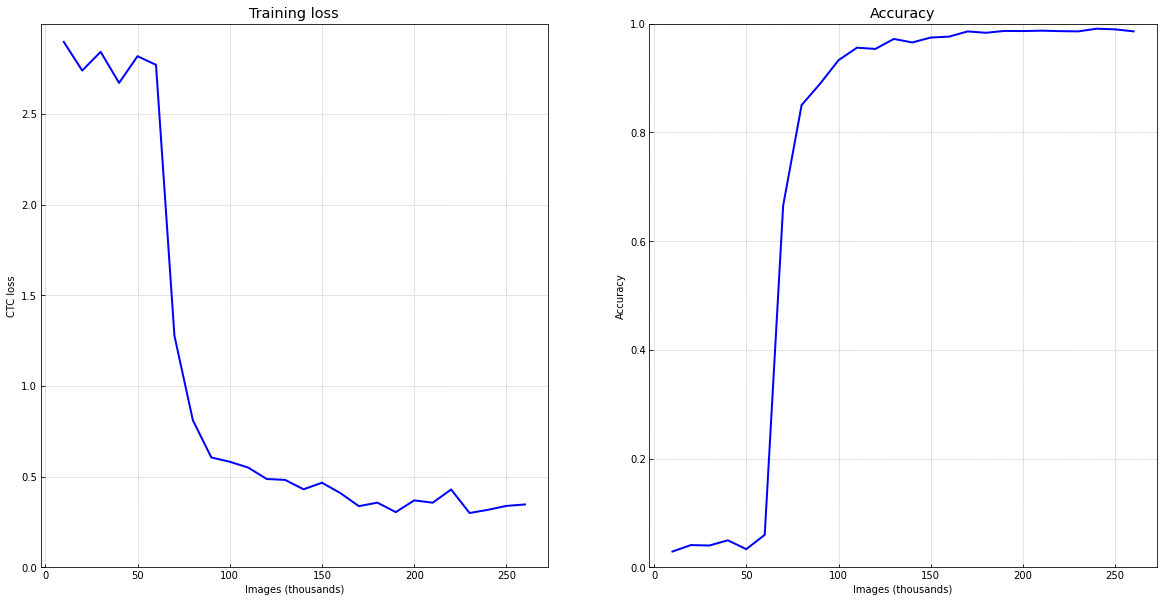

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
Training images 27000
0.9908021894771895


In [ ]:
plt.style.use('bmh')


# fig.style.use()

axes[0].clear()
axes[0].set(title='Training loss',
            xlabel='Images (thousands)',ylabel='CTC loss')
axes[0].set_ylim(ymin=0, ymax=max(losses_axis) + 0.1)
# axes[0].plot(iter_axis, losses_axis, 'b-')
                        
axes[1].clear()
axes[1].set(title='Accuracy',
            xlabel='Images (thousands)', ylabel='Accuracy')
axes[1].set_ylim(ymin=0, ymax=1)
# axes[1].plot(iter_axis, accuracy_axis, 'b-')
            
IPython.display.clear_output(wait=True)
IPython.display.display(fig)

print(plt.style.available)
print("Training images", split)
print(max(accuracy_axis))

На тестовых примерах значительно лучше показала себя модель easyocr с точностью = 96%, в то время как у кастомной получилось только 59%. Похоже, что кастомная модель переобучилась на сгенерированном датасете (в добавок, скорее всего, не удалось сгенерировать лучшим образом под реальные данные). Хотя примеров для тестового датасета немного и половина из них не оптимального качества. Не исключено, что на бОльших данных модели повели себя бы иначе. 

Не все получилось попробовать что планировал за время выполнения задания. Но возможные варианты для улучшения:
- сгенерировать или собрать более качественный, обширный и разнообразный  тренировочный датасет, лучше всего с паспортами (для кастомной модели кажется одним из наиболее важных пунктов, на других сгенерированных датасетах точность была хуже). вроде как и у easyocr и у tesseract есть возможности дообучения на сторонних датасетах
- попробовать другую модель (планировал еще попробовать реализовать 
отсюда https://github.com/Deepayan137/Adapting-OCR)
- проводить более тонкую предобработку изображений. в частности видится потенциал даже у easyocr модели (на некоторых фильтрах получалась точность 97-98%). возможно, если б изначально настраивал предобработку на кастомную модель, удалось бы получить точность на ней также значительно выше
- попробовать не вычленять отдельно фамилии, имена и отчества, а другие способы обработки фото паспортов с соотвествущими подходами и моделями.